In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import kagglehub
path = kagglehub.dataset_download("nirmalsankalana/rice-leaf-disease-image")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/rice-leaf-disease-image


In [7]:
import numpy as np 
import pandas as pd 
import cv2 
import os
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [8]:
import torch
import torchvision
import torchvision.transforms as TT
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from collections import OrderedDict, defaultdict

In [9]:
def load_and_resize_image(file_path, target_shape=(128, 128)):
    image = cv2.imread(file_path)
    resized_image = cv2.resize(image, target_shape)
    return resized_image

In [10]:
def load_image_class_by_directory(image_dir):
    image_files = os.listdir(image_dir)
    images = []
    for file in image_files:
        if file.endswith('.jpg') or file.endswith('.JPG'):   
            image_path = os.path.join(image_dir, file)
            resized_image = load_and_resize_image(image_path)
            images.append(resized_image)

    print(f"Num of images: {len(images)}")        
    print(f"Single image shape before flattening: {images[0].shape}")
    return images

In [11]:
load_Bacterialblight = load_image_class_by_directory('/kaggle/input/rice-leaf-disease-image/Bacterialblight')
load_Blast = load_image_class_by_directory('/kaggle/input/rice-leaf-disease-image/Blast')
load_Brownspot = load_image_class_by_directory('/kaggle/input/rice-leaf-disease-image/Brownspot')
load_Tungro = load_image_class_by_directory('/kaggle/input/rice-leaf-disease-image/Tungro')

Num of images: 1584
Single image shape before flattening: (128, 128, 3)
Num of images: 1440
Single image shape before flattening: (128, 128, 3)
Num of images: 1600
Single image shape before flattening: (128, 128, 3)
Num of images: 1308
Single image shape before flattening: (128, 128, 3)


In [13]:
class ClassifyDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, names, classes, img_size, transforms=None):
        super().__init__()
        assert Path(data_path).exists() and Path(data_path).is_dir(), EOFError
        self.data_path = Path(data_path)
        self.classes = classes
        self.img_size = img_size
        if transforms is not None:
            assert callable(transforms), Exception('transforms can not be callable!!!')
        self.transforms = transforms
        
        self.img_names = []
        self.labels = []
        for i, c in enumerate(self.classes):
            self.img_names += names[c]
            self.labels += len(names[c]) * [i]
    
    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        # get label and read image
        label = self.labels[index]
        img_path = self.data_path / self.classes[label] / self.img_names[index]
        
        img = cv2.imread(img_path.as_posix())
        
        # preprocess image
        img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2RGB)
        img = cv2.resize(src=img, dsize=2 * [self.img_size], interpolation=cv2.INTER_LINEAR)
        img = torch.from_numpy(img).permute(2, 1, 0)
        
        # augmentation
        if self.transforms is not None:
            img = self.transforms(img)
        img = (img / 255).float()
        
        return img, label

    def sample(self, num_samples):
        imgs, labels = [], []
        for sample_idx in np.random.choice(a=len(self), size=num_samples):
            img, label = self[sample_idx]
            imgs.append(img)
            labels.append(label)
        return torch.stack(imgs), torch.LongTensor(labels)
            
    def show_samples(self, num_samples=None, figsize=(20, 20)):
        labels = np.array(self.labels)
        uniques = np.unique(ar=labels)
        if num_samples is None:
            num_samples = len(uniques)

        # make image grid
        imgs = []
        for u in uniques:
            sample_idxs = np.random.choice(np.where(labels == u)[0], size=num_samples)
            imgs.append(make_grid([self[idx][0] for idx in sample_idxs], nrow=num_samples))
        imgs = make_grid(imgs, nrow=1)
        
        plt.figure(figsize=figsize)
        plt.imshow(imgs.permute(1, 2, 0))

        # set labels for ticks
        grid_size = imgs.shape[1] / num_samples
        ticks = np.linspace(grid_size / 2, imgs.shape[1] - grid_size / 2, len(uniques))
        plt.xticks(ticks=[])
        plt.yticks(ticks=ticks, labels=train_dataset.classes)

        plt.show()

     

In [14]:
transforms = TT.Compose([
    TT.RandomCrop(size=224, padding=round(0.2 * 224)),
    TT.RandAugment(num_ops=2, magnitude=9),
    TT.AugMix(severity=3, mixture_width=3)
])
transforms

Compose(
    RandomCrop(size=(224, 224), padding=45)
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    AugMix(severity=3, mixture_width=3, chain_depth=-1, alpha=1.0, all_ops=True, interpolation=InterpolationMode.BILINEAR, fill=None)
)

In [15]:
class CrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_fn = torch.nn.CrossEntropyLoss()
    
    def forward(self, preds, targets):
        # compute loss
        loss = self.loss_fn(preds, targets)
        
        # compute metrics
        metrics = {'loss': loss.item()}
        if preds.size() == targets.size():
            targets = targets.argmax(dim=-1)
        preds = preds.argmax(dim=-1)
        metrics['acc'] = torch.mean((preds == targets).float()).item()
        return loss, metrics

In [16]:
def train_model(datasets, model, criterion, optimizer, lr_scheduler, eval_metric, eval_func,
                epochs=10, batch_size=16, max_grad_norm=None, cuda=False, num_workers=8, ckpt_dir=''):
    ckpt_dir = Path(ckpt_dir)
    assert ckpt_dir.exists() and ckpt_dir.is_dir(), EOFError
    assert callable(eval_func), TypeError
    assert len(datasets) == 2, ValueError
    assert isinstance(model, torch.nn.Module), TypeError
    assert isinstance(criterion, torch.nn.Module), TypeError
    if cuda:
        model.cuda()
        criterion.cuda()
    
    # create dataloaders
    train_dataloader = torch.utils.data.DataLoader(dataset=datasets[0], batch_size=batch_size, 
                                                   shuffle=True, drop_last=True,
                                                   num_workers=min(os.cpu_count(), num_workers))
    valid_dataloader = torch.utils.data.DataLoader(dataset=datasets[1], batch_size=2 * batch_size, 
                                                   shuffle=False, num_workers=min(os.cpu_count(), num_workers))
    logs = {
        name: defaultdict(list)
        for name in ['train', 'valid']
    }
    best_eval = 0.0

    # run training process
    for epoch in range(epochs):
        print(20 * '>', f'EPOCH {epoch + 1}', 20 * '<')

        model.train()
        criterion.train()
        with tqdm(train_dataloader, desc='Train') as pbar:
            avg_metrics = defaultdict(lambda: 0)
            for i, (X, y) in enumerate(pbar):
                # forward
                if cuda:
                    X, y = X.cuda(), y.cuda()
                y_pred = model(X)

                # compute loss and metrics
                loss, metrics = criterion(y_pred, y)
                optimizer.zero_grad()
                loss.backward()
                if max_grad_norm is not None:
                    nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                # compute average metrics and show traning performance
                alpha = 1 / (i + 1)
                for name, value in metrics.items():
                    avg_metrics[name] = (1 - alpha) * avg_metrics[name] + alpha * value
                pbar.set_postfix(avg_metrics)
            for name, value in avg_metrics.items():
                logs['train'][name].append(value)
        
        model.eval()
        criterion.eval()
        with tqdm(valid_dataloader, desc='Valid') as pbar:
            avg_metrics = defaultdict(lambda: 0)
            for i, (X, y) in enumerate(pbar):
                # forward
                if cuda:
                    X, y = X.cuda(), y.cuda()
                with torch.no_grad():
                    y_pred = model(X)

                # compute loss and metrics
                loss, metrics = criterion(y_pred, y)

                # compute average metrics and show performance
                alpha = 1 / (i + 1)
                for name, value in metrics.items():
                    avg_metrics[name] = (1 - alpha) * avg_metrics[name] + alpha * value
                pbar.set_postfix(avg_metrics)
            for name, value in avg_metrics.items():
                logs['valid'][name].append(value)
        
        if eval_func(best_eval, avg_metrics[eval_metric]):
            best_eval = avg_metrics[eval_metric]
            torch.save(obj=model.state_dict(), f=ckpt_dir / 'best_weights.pt')
            print(20 * '>', f'BEST MODEL SAVED, {eval_metric}: {round(best_eval, 3)}', 20 * '<')
        torch.save(obj=model.state_dict(), f=ckpt_dir / 'last_weights.pt')
        torch.save(obj=logs, f=ckpt_dir / 'train_logs.cache')

        # run scheduler
        lr_scheduler.step()
        print()
        


In [17]:
EPOCHS = 50
BATCH_SIZE = 32

CUDA = torch.cuda.is_available()
EVAL_METRIC = 'acc'
EVAL_FUNC = lambda old, new: old <= new
DATA_PATH = Path('/kaggle/input/rice-leaf-disease-image')
CLASSES = os.listdir(DATA_PATH)
LR = 1e-4
WEIGHT_DECAY = 3e-5
DIV_FACTOR = 10
FINAL_DIV_FACTOR = 100
MAX_GRAD_NORM = 2.0

NUM_WORKERS = 8
CKPT_ROOT = '/kaggle/working/'

Number of classes: 4


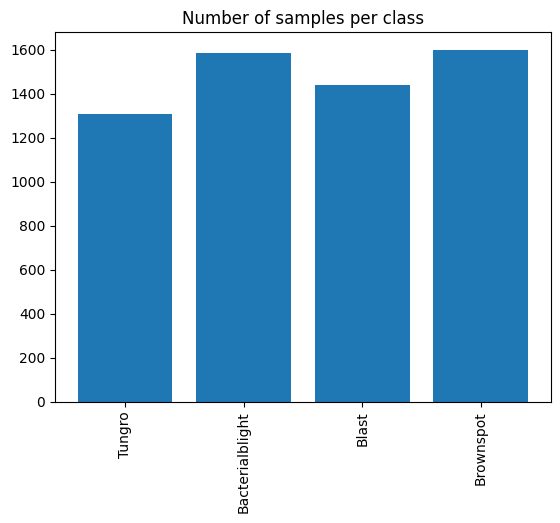

In [18]:
train_img_names = {}
valid_img_names = {}
print(f'Number of classes: {len(CLASSES)}')
counts = {}
img_names = {}
for c in CLASSES:
    img_names = os.listdir(DATA_PATH / c)
    train_img_names[c], valid_img_names[c] = train_test_split(img_names, test_size=0.2, random_state=42)
    counts[c] = len(img_names)
plt.bar(x=counts.keys(), height=counts.values())
plt.xticks(rotation=90)
plt.title('Number of samples per class')
plt.show()

In [19]:
train_dataset = ClassifyDataset(data_path=DATA_PATH, 
                                names=train_img_names,
                                classes=CLASSES, 
                                img_size=224, 
                                transforms=transforms)
valid_dataset = ClassifyDataset(data_path=DATA_PATH, 
                                names=valid_img_names,
                                classes=CLASSES, 
                                img_size=224)
len(train_dataset), len(valid_dataset)

(4745, 1187)

In [20]:
%cd {CKPT_ROOT}
!mkdir vgg16
ckpt_dir = f'{CKPT_ROOT}/vgg16'

model = torchvision.models.vgg16(num_classes=len(CLASSES))

# define criterion, optimizer and learning rate scheduler
criterion = CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, 
                                                   max_lr=LR, total_steps=EPOCHS,
                                                   div_factor=DIV_FACTOR, 
                                                   final_div_factor=FINAL_DIV_FACTOR, 
                                                   verbose=True)

# run train
train_model(datasets=(train_dataset, valid_dataset), 
            model=model, criterion=criterion, 
            optimizer=optimizer, lr_scheduler=lr_scheduler,
            eval_metric=EVAL_METRIC, eval_func=EVAL_FUNC,
            epochs=EPOCHS, batch_size=BATCH_SIZE,
            cuda=CUDA, num_workers=NUM_WORKERS, ckpt_dir=ckpt_dir)

/kaggle/working


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


>>>>>>>>>>>>>>>>>>>> EPOCH 1 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:07<00:00,  2.61it/s, loss=1.06, acc=0.481]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 0.481 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 2 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.28it/s, loss=0.964, acc=0.623]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 0.623 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 3 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.834, acc=0.669]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 0.669 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 4 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.32it/s, loss=0.687, acc=0.73] 


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 0.73 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 5 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.31it/s, loss=0.729, acc=0.713]



>>>>>>>>>>>>>>>>>>>> EPOCH 6 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.32it/s, loss=0.674, acc=0.745]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 0.745 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 7 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.29it/s, loss=0.585, acc=0.783]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 0.783 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 8 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.31it/s, loss=0.493, acc=0.823]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 0.823 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 9 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.369, acc=0.855]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 0.855 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 10 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.29it/s, loss=0.367, acc=0.855]



>>>>>>>>>>>>>>>>>>>> EPOCH 11 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.31it/s, loss=0.315, acc=0.892]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 0.892 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 12 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.391, acc=0.857]



>>>>>>>>>>>>>>>>>>>> EPOCH 13 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.319, acc=0.883]



>>>>>>>>>>>>>>>>>>>> EPOCH 14 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.32it/s, loss=0.328, acc=0.863]



>>>>>>>>>>>>>>>>>>>> EPOCH 15 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.167, acc=0.943]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 0.943 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 16 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.31it/s, loss=0.249, acc=0.902]



>>>>>>>>>>>>>>>>>>>> EPOCH 17 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.31it/s, loss=0.0897, acc=0.976]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 0.976 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 18 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.31it/s, loss=0.0753, acc=0.976]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 0.976 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 19 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.0808, acc=0.97] 



>>>>>>>>>>>>>>>>>>>> EPOCH 20 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.0551, acc=0.98] 


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 0.98 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 21 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.32it/s, loss=0.0621, acc=0.981]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 0.981 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 22 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.31it/s, loss=0.0596, acc=0.986]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 0.986 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 23 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.25it/s, loss=0.0571, acc=0.979]



>>>>>>>>>>>>>>>>>>>> EPOCH 24 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.31it/s, loss=0.0279, acc=0.994]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 0.994 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 25 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.31it/s, loss=0.0335, acc=0.992]



>>>>>>>>>>>>>>>>>>>> EPOCH 26 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.0712, acc=0.974]



>>>>>>>>>>>>>>>>>>>> EPOCH 27 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.31it/s, loss=0.119, acc=0.953] 



>>>>>>>>>>>>>>>>>>>> EPOCH 28 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.0248, acc=0.99]  



>>>>>>>>>>>>>>>>>>>> EPOCH 29 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.29it/s, loss=0.0576, acc=0.984]



>>>>>>>>>>>>>>>>>>>> EPOCH 30 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.29it/s, loss=0.0226, acc=0.993] 



>>>>>>>>>>>>>>>>>>>> EPOCH 31 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.0282, acc=0.992]



>>>>>>>>>>>>>>>>>>>> EPOCH 32 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.32it/s, loss=0.0363, acc=0.987]



>>>>>>>>>>>>>>>>>>>> EPOCH 33 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.00527, acc=0.999]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 0.999 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 34 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.043, acc=0.98]   



>>>>>>>>>>>>>>>>>>>> EPOCH 35 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.28it/s, loss=0.00684, acc=0.998]



>>>>>>>>>>>>>>>>>>>> EPOCH 36 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.00318, acc=1]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 1.0 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 37 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.00271, acc=1]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 1.0 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 38 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.31it/s, loss=0.00191, acc=1] 


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 1.0 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 39 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.00448, acc=1]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 1.0 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 40 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.00074, acc=1] 


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 1.0 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 41 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.00151, acc=1]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 1.0 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 42 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.000502, acc=1]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 1.0 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 43 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.000618, acc=1]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 1.0 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 44 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s, loss=0.000274, acc=1]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 1.0 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 45 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.31it/s, loss=0.000321, acc=1]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 1.0 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 46 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.28it/s, loss=0.000452, acc=1]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 1.0 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 47 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.29it/s, loss=0.000297, acc=1]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 1.0 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 48 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.29it/s, loss=0.000283, acc=1]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 1.0 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 49 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.31it/s, loss=0.000267, acc=1]


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 1.0 <<<<<<<<<<<<<<<<<<<<

>>>>>>>>>>>>>>>>>>>> EPOCH 50 <<<<<<<<<<<<<<<<<<<<


Valid: 100%|██████████| 19/19 [00:08<00:00,  2.31it/s, loss=0.00027, acc=1] 


>>>>>>>>>>>>>>>>>>>> BEST MODEL SAVED, acc: 1.0 <<<<<<<<<<<<<<<<<<<<

